In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11, 12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v4'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0911_180154'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset length: 6019


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            model.metrics.update(pred,batch)
            # pred['mid_output']['sampled_feats'].retain_grad()
            # loss = model.loss_func(pred,batch)
            # loss[0].backward()
            # vis_result = viz(batch,pred)
            # if i == 25:
            break   
        
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)
# model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


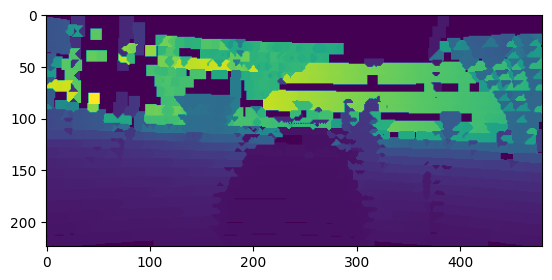

In [4]:
plt.imshow(batch['depth'][0,1].cpu().numpy())

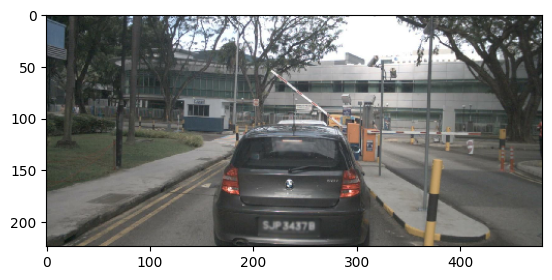

In [5]:
plt.imshow(batch['image'][0,1].permute(1,2,0).cpu().numpy())

/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


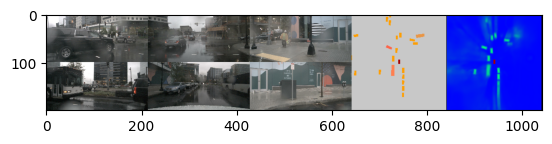

In [3]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)[None]
    elif isinstance(v, list):
        if isinstance(v[0], torch.Tensor):
            batch[k] = [i.to(device) for i in v]
    else:
        batch[k] = v
with torch.no_grad():
    pred = network(batch)
# pred = None
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

In [51]:
# attention = pred['mid_output']['attention']
# attention = rearrange(attention, '(b h w) m 1 p -> b h w m p', b=4, h=200, w=200)
stage = 1
h = w = 50 if stage == 0 else 200
points = rearrange(pred['mid_output'][f"stage_{stage}"]['sample_points_cam'], 'b (h w) p d -> b h w p d',h=h, w=w)
pos_3d = rearrange(pred['mid_output'][f"stage_{stage}"]['pos_3d'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
reference_points = rearrange(pred['mid_output'][f"stage_{stage}"]['reference_points'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
weight = rearrange(pred['mid_output'][f"stage_{stage}"]['weight'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)

(-0.5, 199.5, 199.5, -0.5)

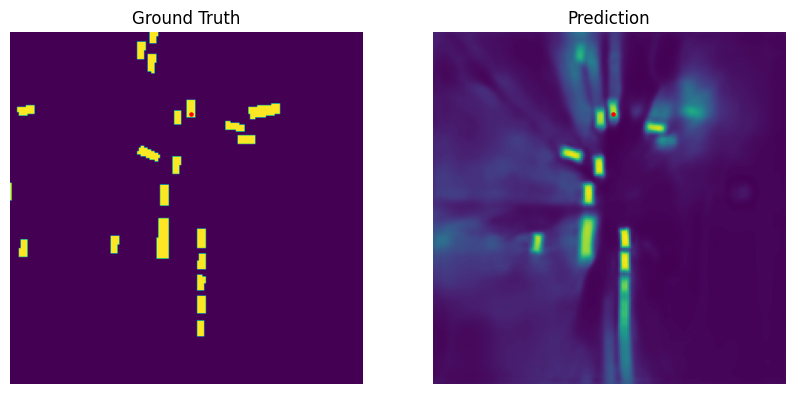

In [64]:
batch_index = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
y = 46
x = 102
vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[batch_index,0].detach().cpu().numpy())
ax1.scatter([x],[y], s=5, c='r')
# ax1.scatter([x+2],[y], s=2, c='g')
# ax1.scatter([x+4],[y], s=2, c='b')
ax1.set_title('Ground Truth')
ax1.axis('off')

ax2.imshow(((pred['VEHICLE'][batch_index,0].sigmoid().detach().cpu())).numpy())
ax2.scatter([x],[y], s=5, c='r')
ax2.set_title('Prediction')
# plt.title('2D')
ax2.axis('off')

In [53]:
bev_prediction_index = pred['VEHICLE'][batch_index,0,y,x].sigmoid()
if stage == 0:
    y = y // 4
    x = x // 4

pts_2d = points[batch_index, y, x]
pos_3d_index = pos_3d[batch_index, y, x]
reference_points_index = reference_points[batch_index, y, x]
weight_index = weight[batch_index, y, x]
mask = (pts_2d[:,0] > 0) & (pts_2d[:,0] < 1) & (pts_2d[:,1] > 0) & (pts_2d[:,1] < 1)
pts_2d = pts_2d[mask].cpu().numpy()
pos_3d_index = pos_3d_index[mask].cpu().numpy()
reference_points_index = reference_points_index[mask].cpu().numpy()
weight_index = weight_index[mask].cpu().numpy()

pts_2d[:, 0] *= 480
pts_2d[:, 1] *= 224

BEV Prediction tensor(0.8295)
Sampled points: [26.83   -1.0962 -0.6248],	 pos 2d: [24.0209 -0.7147 -0.0875], 	weight: [0.4349]
Sampled points: [26.7787 -1.0933 -0.1957],	 pos 2d: [26.8217 -0.811   0.1111], 	weight: [0.9826]
Sampled points: [26.8715 -1.1175  0.1922],	 pos 2d: [29.6331 -0.9752  0.3765], 	weight: [0.4639]
Sampled points: [26.837  -1.0604  0.556 ],	 pos 2d: [59.6406 -1.8032  0.3023], 	weight: [0.]
Sampled points: [26.8237 -1.1989  0.9245],	 pos 2d: [90.3915 -3.1126  0.4274], 	weight: [0.]
Sampled points: [26.8781 -1.0715  1.3652],	 pos 2d: [87.3151 -2.7236  1.8948], 	weight: [0.]
Sampled points: [26.9316 -1.3275  1.8052],	 pos 2d: [92.8761 -3.679   3.4514], 	weight: [0.]
Sampled points: [26.6225 -1.1804  2.3437],	 pos 2d: [24.1724 -0.7922  2.0869], 	weight: [0.5369]


(-0.5, 479.5, 223.5, -0.5)

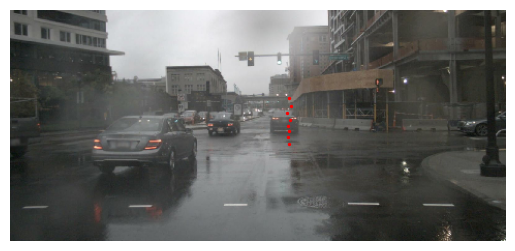

In [59]:
cam_index = 1
print("BEV Prediction", bev_prediction_index)
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
for i in range(len(pts_2d)):
    print(f"Sampled points: {np.round(reference_points_index[i], 4)},\t pos 2d: {np.round(pos_3d_index[i], 4)}, \tweight: {np.round(weight_index[i], 4)}")
    # print(f"Sampled points: {np.round(reference_points_index[i], 4)}")
    # print(att_[head_index,i])

    # plt.scatter(pts_2d[i,0], pts_2d[i,1], s=6, c='g', alpha=max(0.0, np.round(weight_index[i], 4)))
    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=2, c='r')
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], alpha=max(float(att_[head_index,i]), 0.1), s=4, c='r')
plt.axis('off')

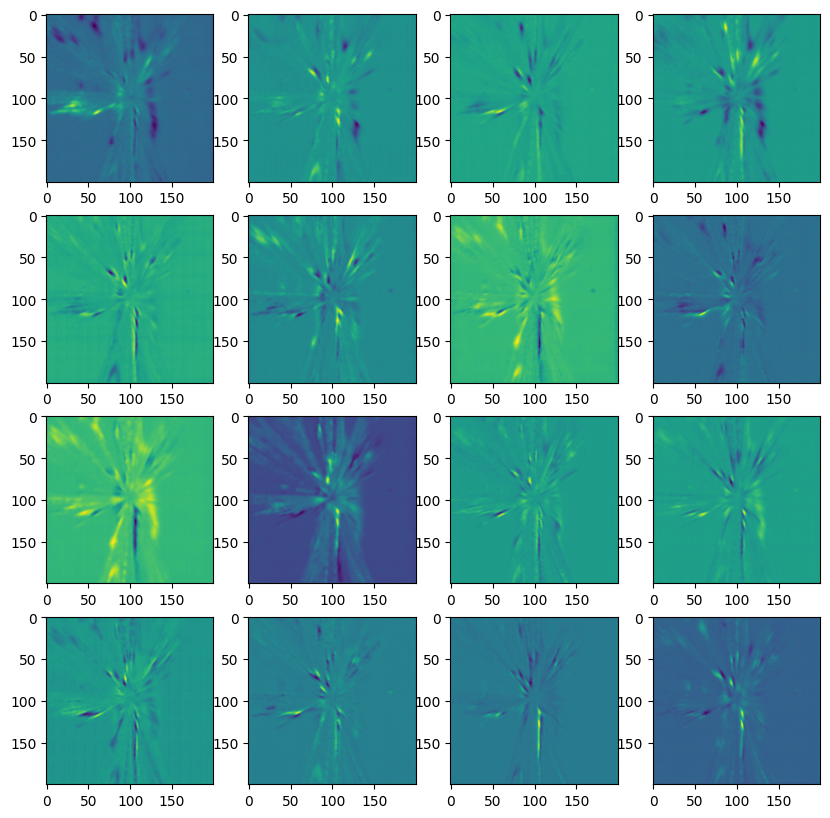

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
feat = pred['mid_output']['inter_output'][1][0].permute(1,2,0).view(-1, 128).cpu().numpy()
# feat = pca.fit_transform(feat).reshape(200,200,128)
feat = feat.reshape(200,200,128)
row, column = 4, 4
fig, ax = plt.subplots(row, column, figsize=(10, 10))
for i in range(row):
    for j in range(column):
        ax[i][j].imshow(feat[:,:,16+ i * row + j])

In [ ]:
depth = pred['mid_output']['pred_depth'][0].permute(1,0,2,3).view(3, -1).cpu().numpy()
print(depth.shape)
plt.scatter(depth[0,:], depth[1,:])

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create a 3D scatter plot
scatter = go.Scatter3d(
    x=depth[0],
    y=depth[1],
    z=depth[2],
    mode='markers',
    marker=dict(
        size=5,
        color=pred['mid_output']['pred_depth'][0,3,2],            # Color by the z-value
        colorscale='Viridis',
        opacity=0.1
    )
)

# Set up the layout
layout = go.Layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0) # Remove margins
)

# Combine the plot and layout
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
pio.show(fig)


In [ ]:
from nuscenes.nuscenes import NuScenes

# Load the nuScenes dataset (mini-split, in this case).
nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=False)

In [ ]:
from nuscenes.utils.data_classes import LidarPointCloud
import os
from pyquaternion import Quaternion

sample_rec = nusc.get('sample', batch['token'])
min_distance = 1.0

sample_data_token = sample_rec['data']['LIDAR_TOP']
current_sd_rec = nusc.get('sample_data', sample_data_token)
# Load up the pointcloud and remove points close to the sensor.
current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))
current_pc.remove_close(min_distance)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
current_cs_rec = nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
current_pc.rotate(Quaternion(current_cs_rec['rotation']).rotation_matrix)
current_pc.translate(np.array(current_cs_rec['translation']))

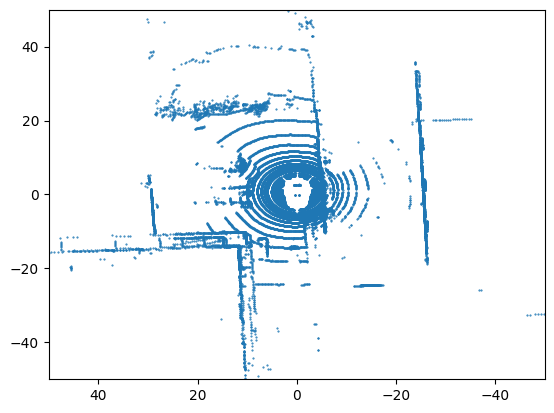

In [ ]:
lidar_points = batch['lidar']
# lidar_points[2, :] = 1
# lidar_points = batch['view'][0].cpu().numpy() @ lidar_points
plt.scatter(lidar_points[1], lidar_points[0], s=0.25)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

In [ ]:
lidar2img = batch['lidar2img'][0] # N 4 4
lidar2img = lidar2img @ batch['bev_augm'][0].inverse()

lidar_points = torch.from_numpy(lidar_points) # 4 P
lidar_points = torch.cat([lidar_points, torch.ones_like(lidar_points[0:1])], dim=0)
lidar_points = torch.matmul(lidar2img, lidar_points)[:, :3] # N 3 P
depth = lidar_points[:, 2:3]
homo_nonzero = torch.maximum(depth, torch.zeros_like(depth) + 1e-6)
lidar_points = lidar_points[:, 0:2] / homo_nonzero

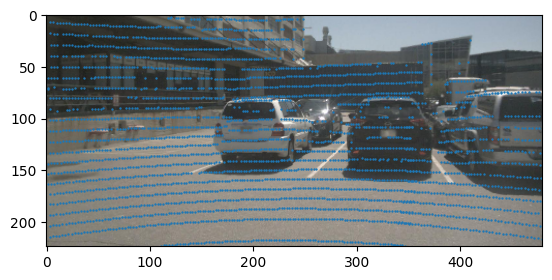

In [ ]:
valid_mask = ((depth > 1e-6) \
        & (lidar_points[:, 1:2] > 1)
        & (lidar_points[:, 1:2] < 224 - 1)
        & (lidar_points[:, 0:1] > 1)
        & (lidar_points[:, 0:1] < 480 -1)
)
cam_index = 3
plt.imshow(batch['image'][0,cam_index].permute(1,2,0))
lidar_points_camera = lidar_points[cam_index][:, valid_mask[cam_index,0]]
plt.scatter(lidar_points_camera[0], lidar_points_camera[1], s=0.5)
depth_cam = torch.zeros((224,480))
lidar_points_camera = torch.round(lidar_points_camera).int()
depth_cam[lidar_points_camera[1], lidar_points_camera[0]] = depth[cam_index][0, valid_mask[cam_index,0]]

In [ ]:
depth[cam_index][0, valid_mask[cam_index,0]]

tensor([55.5179, 44.6248, 46.2549,  ..., 33.2371, 50.0585, 50.1923])

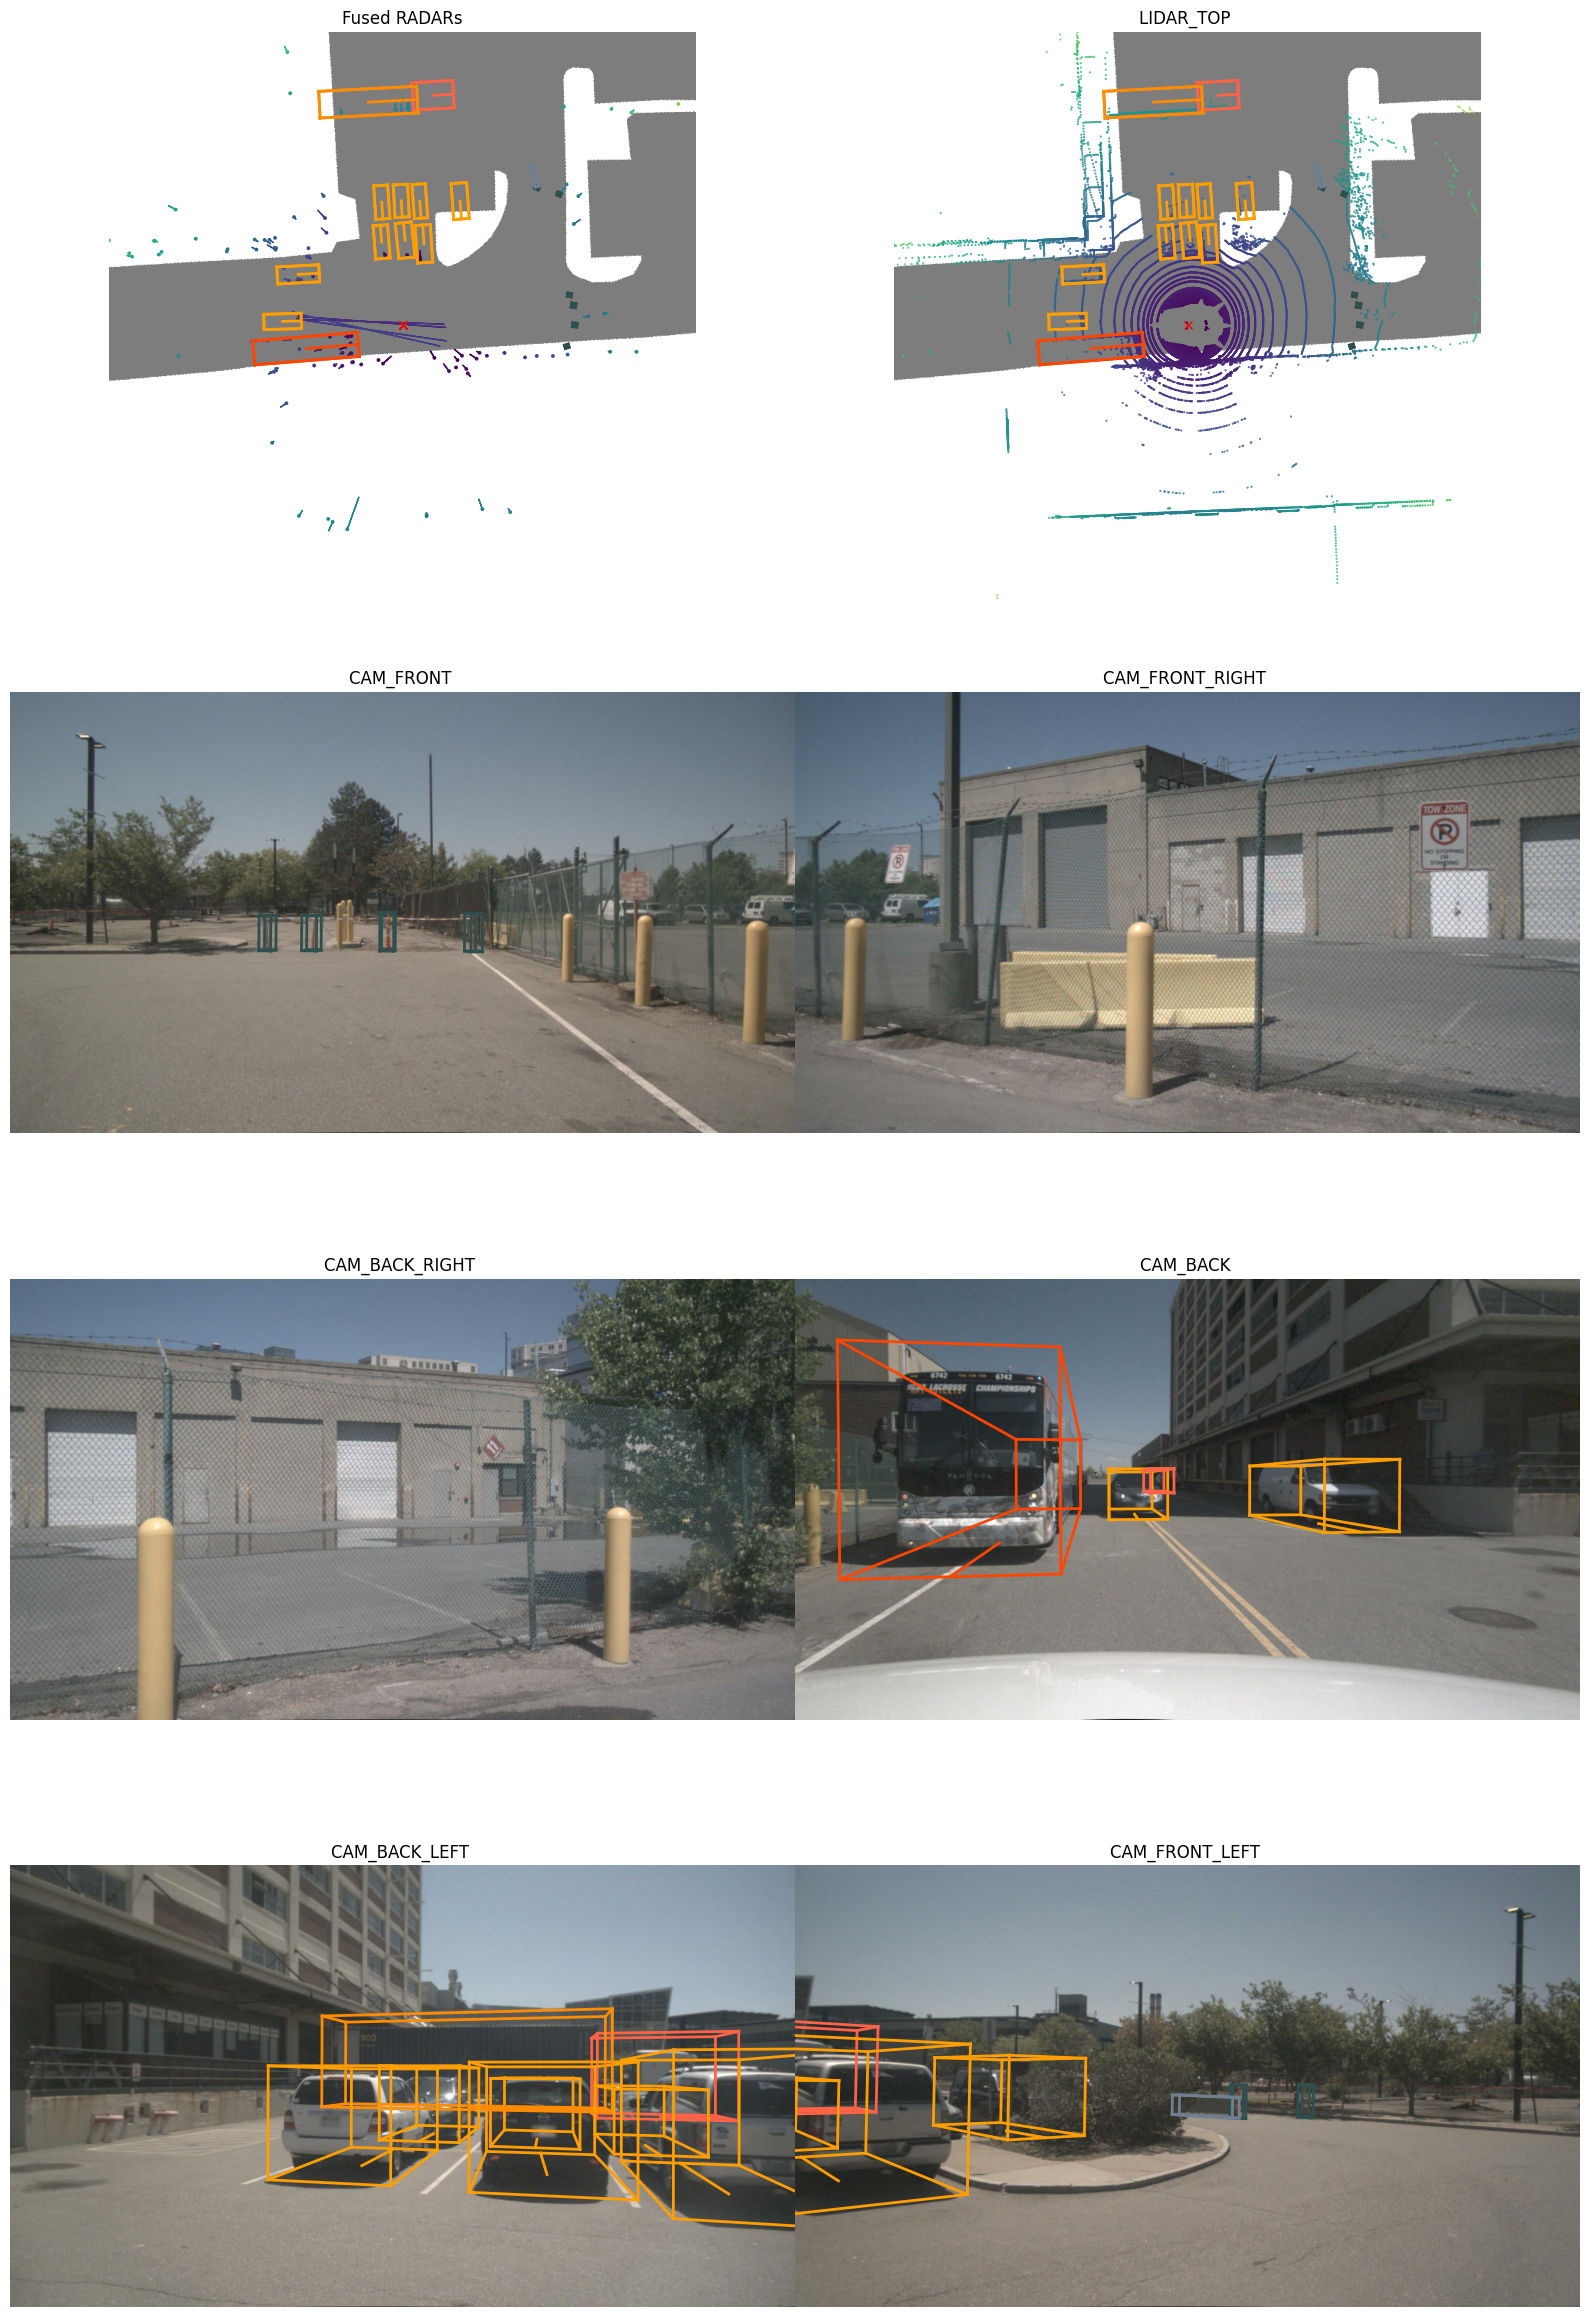

In [ ]:
nusc.render_sample(batch['token'])

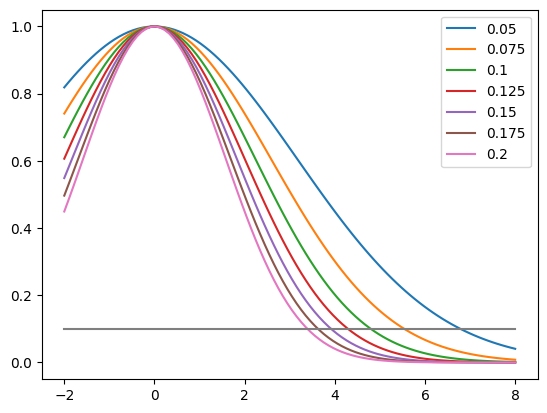

In [50]:
import torch
tensor1 = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tensor2 = torch.tensor([[1.1, 2.1, 3.1], [10.0, 10.0, 10.0]])

# 1. Compute the difference between the two tensors
difference = tensor1 - tensor2

# 2. Compute the norm (Euclidean norm) along the last dimension
norm = torch.norm(difference, dim=1)

# 3. Apply a thresholding function
# Here, we use a Gaussian-like function: exp(-alpha * norm^2)
# alpha = 0.075  # You can tune this parameter
# output = torch.exp(-alpha * norm**2)
# print(norm)
# print(output)
offset = 2
x = torch.linspace(-offset, offset + 6, 100, dtype=torch.float32)
alphas = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
# alphas = [0.85, 0.72, 0.74, 0.76, 0.78, 0.8, 0.9]
# alphas = [alpha * 8 for alpha in alphas]
for alpha in alphas:
    y = torch.exp(-alpha * x ** 2)

    # positive_mask = (x >= 0).float()
    # negative_mask = (x < 0).float()
    # gauss_positive = torch.exp(-0.1 * (x / alpha) ** 2)
    # gauss_negative = torch.exp(-0.1 * (x / 0.4) ** 2)
    # y = gauss_positive * positive_mask + gauss_negative * negative_mask

    plt.plot(x.numpy(), y.numpy(), label=str(alpha))

plt.plot(x, [0.1] * 100)
plt.legend()

In [34]:
torch.exp(-0.1 * (torch.tensor([-0.4]) / 0.1) ** 2)

tensor([0.2019])

In [ ]:
def parse_pose(record, *args, **kwargs):
    return get_pose(record['rotation'], record['translation'], *args, **kwargs)

def get_transformation_matrix(R, t, inv=False):
    pose = np.eye(4, dtype=np.float32)
    pose[:3, :3] = R if not inv else R.T
    pose[:3, -1] = t if not inv else R.T @ -t

    return pose


def get_pose(rotation, translation, inv=False, flat=False):
    if flat:
        yaw = Quaternion(rotation).yaw_pitch_roll[0]
        R = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).rotation_matrix
    else:
        R = Quaternion(rotation).rotation_matrix

    t = np.array(translation, dtype=np.float32)

    return get_transformation_matrix(R, t, inv=inv)

current_sd_rec = nusc.get('sample_data', sample_data_token)
egolidar = nusc.get('ego_pose', current_sd_rec['ego_pose_token'])
print(parse_pose(egolidar), '\n',parse_pose(egolidar,flat=True))

[[-6.1755800e-01  7.8652388e-01 -1.5229532e-03  1.6734443e+03]
 [-7.8651369e-01 -6.1755824e-01 -4.2428235e-03  9.5222522e+02]
 [-4.2775944e-03 -1.4223661e-03  9.9998987e-01  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]] 
 [[-6.1755872e-01  7.8652477e-01  0.0000000e+00  1.6734443e+03]
 [-7.8652477e-01 -6.1755872e-01  0.0000000e+00  9.5222522e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [ ]:
batch['intrinsics'][0,0]

tensor([[385.2198,   0.3901, 227.6785],
        [ -0.3906, 384.7550,  78.9732],
        [  0.0000,   0.0000,   1.0000]])

In [ ]:
import torch
import torch.nn.functional as F

def fill_zeros_with_nearest(data):
    # Step 1: Identify zeros in the data
    zero_mask = data == 0

    # Step 2: Create an initial distance map where non-zero values have a distance of 0
    # Invert the mask: non-zero -> 0, zero -> 1
    distance_map = zero_mask.float()

    # Step 3: Use convolution to propagate nearest non-zero values
    for _ in range(5):  # Number of iterations depends on how far the nearest value should propagate
        # Apply a convolution with a kernel of all ones
        conv_filter = torch.ones(1, 1, 3, 3, device=data.device)
        propagated_data = F.conv2d(data.unsqueeze(0).unsqueeze(0), conv_filter, padding=1).squeeze(0).squeeze(0)
        propagated_count = F.conv2d(distance_map.unsqueeze(0).unsqueeze(0), conv_filter, padding=1).squeeze(0).squeeze(0)
        
        # Avoid division by zero by masking out zero locations
        propagated_count[propagated_count == 0] = 1  # Avoid division by zero
        new_data = propagated_data / propagated_count

        # Step 4: Update the data where it was zero
        data[zero_mask] = new_data[zero_mask]

        # Update the mask to prevent overwriting valid data in the next iteration
        zero_mask = data == 0

    return data

# Example usage:
data = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 3.0],
    [0.0, 4.0, 0.0, 0.0]
], dtype=torch.float32)

filled_data = fill_zeros_with_nearest(data)
print(filled_data)

tensor([[0.1441, 0.0625, 0.1625, 0.2438],
        [0.2167, 0.2972, 0.3750, 0.6000],
        [0.8000, 0.5000, 1.0000, 3.0000],
        [1.3333, 4.0000, 1.7500, 1.0000]])


In [1]:
import torch
H = 224 // 8
W = 480 // 8
coords_h = torch.arange(H).float() * 224 / H
coords_w = torch.arange(W).float() * 480 / W

In [4]:
torch.stack(torch.meshgrid([coords_w, coords_h])).shape

torch.Size([2, 60, 28])

In [44]:
46.2-39.4

6.800000000000004

In [38]:
torch.tensor([[0.1,0.2,0.3], [0.1,0.2,0.3]]).shape

torch.Size([2, 3])

In [39]:
torch.linalg.norm(torch.tensor([[0.1,0.2,0.3], [0.1,0.2,0.3]]), dim=-1)

tensor([0.3742, 0.3742])

In [36]:
(0.1 ** 2 + 0.2 ** 2 + 0.3 ** 2) ** 0.5

0.37416573867739417